In [2]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_score

In [5]:
df = pd.read_csv('BTC-USD.csv')
df.set_index('Date',inplace = True)
df.head()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,1.192634,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003974,-0.002272,0.004646,0.991144
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,1.048237,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.192634,0.000964,0.003887,1.003974
2017-02-02,0.019630,0.024675,0.012855,1011.799988,-0.028572,0.023030,0.030816,0.012600,66.345006,1.051268,...,905.529332,3,0.008542,0.057675,0.019188,0.018926,1.048237,0.054348,0.055442,1.192634
2017-02-03,0.021676,0.020079,0.026005,1029.910034,0.380309,0.017899,0.024861,0.032145,68.695922,1.035435,...,915.335333,4,-0.079792,0.054832,0.023030,0.030816,1.051268,0.019188,0.018926,1.048237
2017-02-04,0.019645,0.011636,0.006314,1042.900024,-0.229603,0.012613,0.030281,0.045785,70.298572,1.023330,...,926.025239,5,0.055230,0.045565,0.017899,0.024861,1.035435,0.023030,0.030816,1.051268


### Add Prediction Target

In [6]:
df.loc[df['Range'].shift(-1)>df['Avg_Range'], "TARGET"] = 1
df.loc[df['Range'].shift(-1)<=df['Avg_Range'],"TARGET"] = 0

In [7]:
print(f'number of positive targets: {len(df[df.TARGET == 1])}')
print(f'number of negative targets: {len(df[df.TARGET == 0])}')


number of positive targets: 718
number of negative targets: 1227


In [8]:
#Check for NaNs
nan_location = np.where(np.isnan(df))
nan_location

(array([1945]), array([21]))

In [9]:
#Fill NA
df['TARGET'].fillna(0,inplace = True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-26,-0.002980,-0.010731,-0.038218,29267.224609,0.336031,-0.009984,0.055632,33.189608,38.165993,0.977232,...,3,-0.239867,0.057147,-0.003144,0.026300,0.993166,0.019130,0.034313,1.065192,0.0
2022-05-27,-0.010608,-0.016331,0.002290,28627.574219,-0.005230,-0.021856,0.036020,32.436595,36.240181,0.949541,...,4,-0.291202,0.057119,-0.009984,0.055632,0.977232,-0.003144,0.026300,0.993166,0.0
2022-05-28,-0.021487,-0.018129,0.008047,28814.900391,-0.029042,0.006544,0.009117,32.894788,37.238957,1.027560,...,5,-0.298233,0.056286,-0.021856,0.036020,0.949541,-0.009984,0.055632,0.977232,0.0
2022-05-29,0.013879,0.023707,0.010035,29445.957031,-0.490594,0.021900,0.022777,33.634047,40.613855,1.090628,...,6,-0.247068,0.055605,0.006544,0.009117,1.027560,-0.021856,0.036020,0.949541,1.0
2022-05-30,0.014593,0.083111,0.016035,31726.390625,1.170788,0.077445,0.090298,36.313300,50.890862,1.253042,...,0,-0.146443,0.057666,0.021900,0.022777,1.090628,0.006544,0.009117,1.027560,0.0


### Split the Data

In [10]:
df_tts = df.copy()
df_tts.drop(columns = ['Close','Bench_C_Rets','Open','High','Low'],inplace = True)

In [11]:
X = df_tts.iloc[:,:-1]
y = df_tts.iloc[:,-1]

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)
print(f'Shape of X_train : {X_train.shape}')
print(f'Shape of y_train : {y_train.shape}')

Shape of X_train : (1556, 16)
Shape of y_train : (1556,)


### Build Initial Model

In [13]:
is_binary = True
is_optimize_for_precision = True

In [14]:
if is_binary:
    objective = 'binary:logistic'
    eval_metric = 'logloss'
    eval_metric_list = ['error','logloss', eval_metric]
else:
    objective = 'multi:softmax'
    eval_metric = 'mlogloss'
    eval_metric_list = ['merror','mlogloss',eval_metric]

In [15]:
if is_binary and is_optimize_for_precision:
    eval_metric = 'aucpr'
    scoring = 'precision'
elif is_binary and not is_optimise_for_precision:
    eval_metric = 'auc'
    scoring = 'f1'
else:
    scoring = 'accuracy'

In [16]:
#Build First Clasifier Model 0
classifier_0 = XGBClassifier(
    objective = objective,
    booster = 'gbtree',
    eval_metric = eval_metric,
    subsample = 0.8,
    colsample_bytree = 1,
    random_state = 1,
    use_label_encoder = False
)

### Find Hyperparameters

In [17]:
param_grid = {
    'gamma' : [0,0.1,0.2,0.5,1,1.5,2,3,6,12,20],
    'learning_rate' : [0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,0.7,0.8],
    'max_depth': [1,2,3,4,5,6,8,12],
    'n_estimators': [25,50,65,80,100,115,200]
}

In [18]:
#Perform Random Search for Best Hyper params

grid_search = RandomizedSearchCV(estimator = classifier_0, param_distributions = param_grid, scoring = scoring)


In [19]:
best_model = grid_search.fit(X_train,y_train)


In [20]:
hyperparams = best_model.best_params_
ne = hyperparams['n_estimators']
lr = hyperparams['learning_rate']
md = hyperparams['max_depth']
gm = hyperparams['gamma']

print("Recommended Params >>", f"ne: {ne}", f"lr: {lr}", f"md: {md}",f"gm: {gm}")

Recommended Params >> ne: 80 lr: 0.03 md: 4 gm: 20


In [21]:
classifier_1 = XGBClassifier(
    objective = objective,
    booster = 'gbtree',
    eval_metric = eval_metric,
    n_estimators = ne,
    learning_rate = lr,
    max_depth = md,
    gamma = gm,
    subsample = 0.8,
    colsample_bytree = 1,
    random_state = 1,
    use_label_encoder = False
)

In [22]:
eval_set = [(X_train,y_train)]
classifier_1.fit(
    X_train,
    y_train,
    eval_set = eval_set,
    verbose = False
)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=20,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

### Performance Evaluation (Quick Overview)

In [25]:
#Get predictions for training data
train_yhat = classifier_1.predict(X_train)
print("Training Preds: \n", train_yhat[:5])

Training Preds: 
 [0 0 0 0 0]


In [36]:
set(train_yhat)

{0, 1}

In [48]:
#Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

In [49]:
#Training Results
train_results = cross_val_score(classifier_1,X_train,y_train,scoring = scoring,cv=cv,n_jobs =1)

In [51]:
#Brief Review of Training Results
print("Average Accuracy K-Fold: ", round(train_results.mean(),2))
print("Std Deviation K-Fold: ", round(train_results.std(),2))


Average Accuracy K-Fold:  0.72
Std Deviation K-Fold:  0.09


In [54]:
print("Precision Score 0: ", round(precision_score(y_train,train_yhat,average = None)[0],3))
print("Precision Score 0: ", round(precision_score(y_train,train_yhat,average = None)[1],3))

Precision Score 0:  0.68
Precision Score 0:  0.773


### FEature Selection

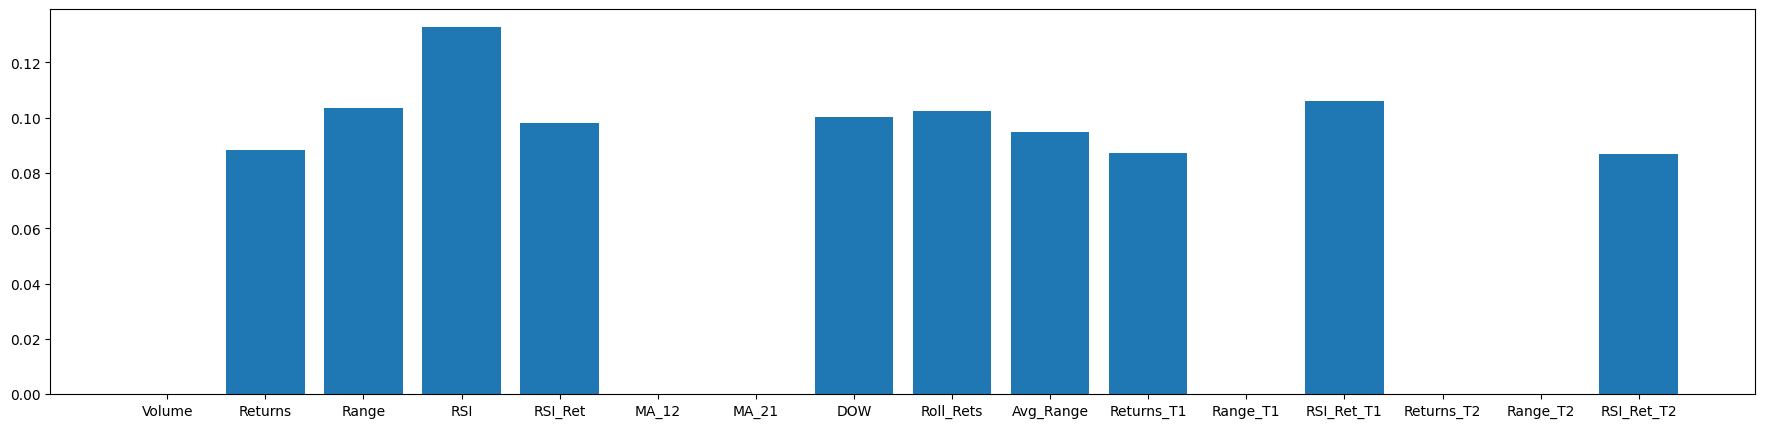

In [55]:
#Plot Feature Importances
fig = plt.figure(figsize = (22,5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.bar(importance_labels,importance_features)
plt.show()

In [58]:
#Select Best Features
mean_feature_importance = importance_features.mean()
i = 0 
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi>mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i+=1
        

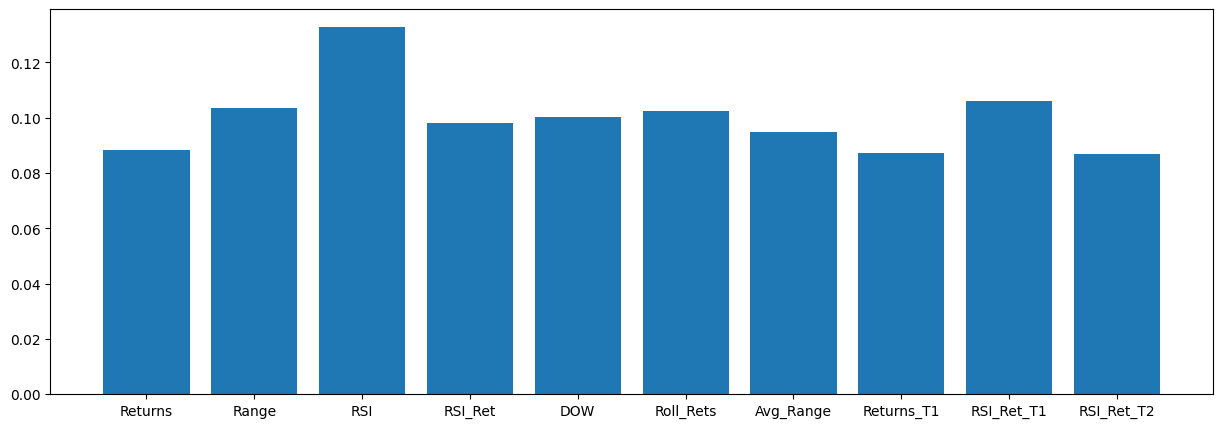

In [59]:
#Plot Recommended Features
fig = plt.figure(figsize = (15,5))
plt.bar(recommended_feature_labels,recommended_feature_score)
plt.show()